In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import zillow

%matplotlib inline
from IPython.core.pylabtools import figsize
from seaborn import plt

# Load and Inspect Data

In [2]:
df = zillow.LoadTabularData("data/")

In [3]:
zillow.LoadImageDataIntoDataFrame(df, "data/")

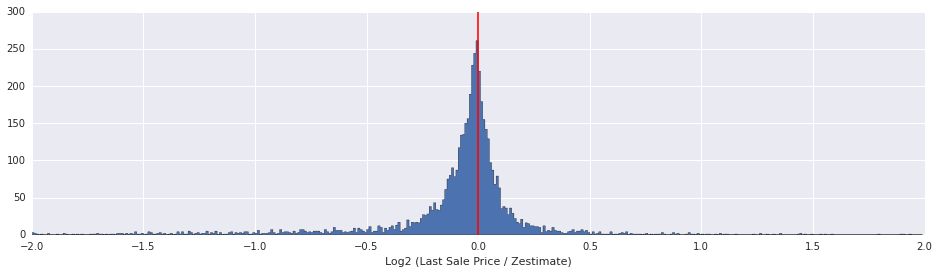

In [17]:
figsize(16, 4)
plt.hist(df.log_sold_to_zestimate, bins=np.arange(-2, 2, 0.01), histtype="stepfilled")
plt.vlines(0, 0, 300, edgecolor="red", alpha=0.9)
plt.xlabel("Log2 (Last Sale Price / Zestimate)")
plt.show()

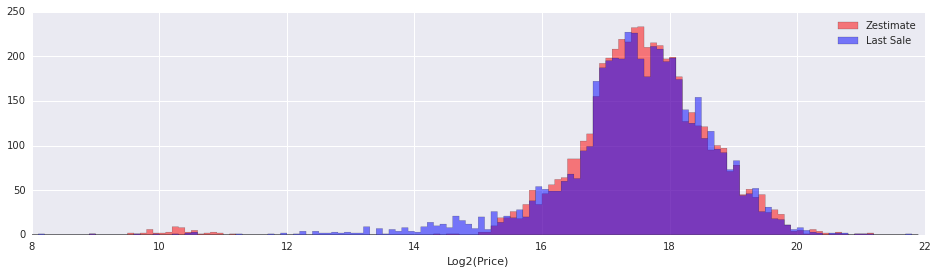

In [18]:
plt.hist(
    np.log2(df.zestimate), bins=np.arange(8, 22, 0.1),
    color="red", alpha=0.5, histtype="stepfilled", label="Zestimate")
plt.hist(
    np.log2(df.last_sold), bins=np.arange(8, 22, 0.1),
    color="blue", alpha=0.5, histtype="stepfilled", label="Last Sale")
plt.xlabel("Log2(Price)")
plt.legend()
plt.show()

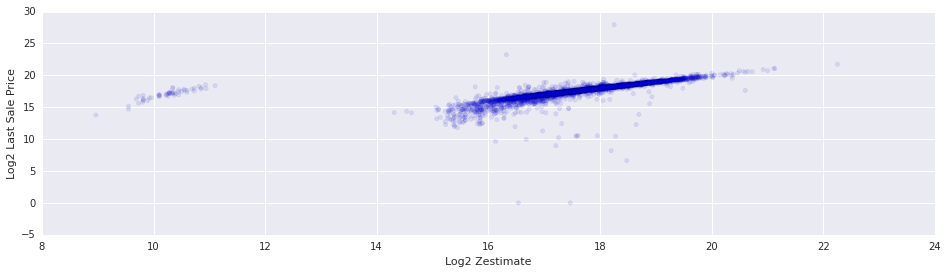

In [114]:
plt.scatter(np.log2(df.zestimate), np.log2(df.last_sold), alpha=0.1)
plt.xlabel("Log2 Zestimate")
plt.ylabel("Log2 Last Sale Price")
plt.show()

# Prepare Data for Training

In [42]:
regions = df.city + df.state
region_encoder = dict((r, n) for n, r in enumerate(regions.unique()))
df["region_code"] = regions.map(lambda r: region_encoder[r])

# Build a network in Keras

In [45]:
from keras import models, layers, optimizers, backend

In [126]:
def ConvolutionalRegressor():
    model = models.Sequential()

    model.add(layers.Conv2D(32, 5, 5, border_mode="same", input_shape=(128, 128, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.pooling.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(48, 3, 3, border_mode="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.pooling.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(64, 3, 3, border_mode="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.pooling.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(96, 3, 3, border_mode="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.pooling.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(128, 3, 3, border_mode="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.pooling.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(1, 4, 4, border_mode="valid"))
    model.add(layers.Reshape((1,)))

    return model

In [127]:
cr = ConvolutionalRegressor()

In [128]:
cr.compile(optimizer="adam", loss="mae")

In [ ]:
cr_history = cr.fit(
    np.array(df.image.tolist()),
    np.array(np.log2(df.last_sold)),
    batch_size=16,
    nb_epoch=5,
    verbose=1,
    validation_split=0.1,
    shuffle=True)

Train on 4500 samples, validate on 501 samples
Epoch 1/5
 544/4500 [==>...........................] - ETA: 562s - loss: 2.6523

In [101]:
df["predictions"] = cr.predict(np.array(df.image.tolist()))

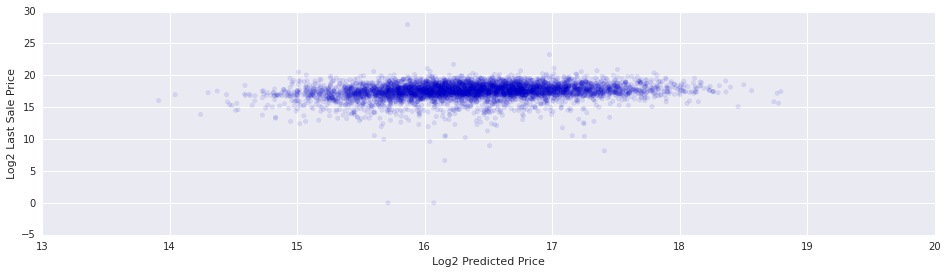

In [113]:
plt.scatter(df.predictions, np.log2(df.last_sold), alpha=0.1)
plt.xlabel("Log2 Predicted Price")
plt.ylabel("Log2 Last Sale Price")
plt.show()